<a href="https://colab.research.google.com/github/apal9569/PPO/blob/main/PPO_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
import gym
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch import nn
from torch.distributions import Normal
from collections import deque
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt

import random

batch_size = 20
epochs = 1000
learning_rate = 1e-2
hidden_size = 8
n_layers = 2
gamma = 0.99

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
class PolModel(nn.Module):
    def __init__(self, in_dim=3):
        super(PolModel, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=in_dim,
                              out_channels=16,
                              kernel_size=5,
                              stride=3,
                              padding=1)
        self.cnn2 = nn.Conv2d(in_channels=16,
                              out_channels=32,
                              kernel_size=5,
                              stride=3,
                              padding=1)        
        
        self.rnn = nn.LSTM(1568, 64, 2, bidirectional=True)
        
        self.mu = nn.Linear(128,1)
        self.std = nn.Linear(128,1)

        self.tanh  = nn.Tanh()
        self.relu = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.relu(self.cnn1(x))
        x = self.relu(self.cnn2(x))
        flatten = torch.flatten(x, start_dim=1)
        if h is None:
          x, h = self.rnn(flatten)
        else: 
          x, h = self.rnn(flatten,h)
        mu = self.tanh(self.mu(x))
        std = torch.exp(self.tanh(self.std(x)))
        dist = Normal(mu, std)
  
        return dist, h
    
    def sample_act(self,state, h):
        dist, h = self.forward(state, h)
        action = dist.sample()
        return dist, torch.clamp(action, -2., 2.), h
    
class ValModel(nn.Module):
    def __init__(self, in_dim):
        super(ValModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=in_dim,
                              out_channels=16,
                              kernel_size=5,
                              stride=3,
                              padding=1)
        self.cnn2 = nn.Conv2d(in_channels=16,
                              out_channels=32,
                              kernel_size=5,
                              stride=3,
                              padding=1)
        
        self.rnn = nn.LSTM(1568, 64, 2, bidirectional=True)
        
        self.fc1 = nn.Linear(128, 1)
        # self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        x = self.relu(self.cnn1(x))
        x = self.relu(self.cnn2(x))
        flatten = torch.flatten(x, start_dim=1)
        if h is None:
          x, h = self.rnn(flatten)
        else: 
          x, h = self.rnn(flatten,h)
        x = self.fc1(x)
        # x = self.fc2(x)
        return x, h
    
class History:
    def __init__(self):
        self.states, self.actions, self.rewards, self.log_probs, self.values, self.dones = [], [], [], [], [], []
    
    def append(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.dones.clear()
        self.log_probs.clear()
        self.values.clear()


In [ ]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")
gamma = 0.9
epsilon = 0.2

data_collections = 400
train_epoch = 30
obs_dim = 3
hidden_weights_actor = None
hidden_weights_critic = None

In [ ]:
from google.colab.patches import cv2_imshow
def resize(img):
  img_dim = (64, 64)
  crop_proportions = (0.2, 0.2, 0.8, 0.8)
  crop_dim = (
      int(crop_proportions[0] * img.shape[0]),
      int(crop_proportions[1] * img.shape[1]),
      int(crop_proportions[2] * img.shape[0]),
      int(crop_proportions[3] * img.shape[1])
  )
  input_channels = 3

  img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
  img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
  state = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0
  return state

import cv2
from google.colab.patches import cv2_imshow

def dataCollection():
    obs = env.reset()
    state = np.array(env.render())[0]
    state = resize(state)
    score = 0
    for i in range(data_collections):
        global hidden_weights_actor 
        global hidden_weights_critic

        state = torch.FloatTensor(state).to(device)
        dist, action, hidden_weights_actor = polModel.sample_act(state, hidden_weights_actor)

        value, hidden_weights_critic = valModel(state, hidden_weights_critic)

        action_taken = action.detach().cpu().numpy()[0]
        next, reward, done, _ = env.step(action_taken)

        next_state = np.array(env.render())[0]

        reward = np.reshape(reward, (1, -1))
        done = np.reshape(done, (1, -1))
        next_state = resize(next_state)
        history.append(state, action, dist.log_prob(action), value, torch.FloatTensor(reward).to(device), torch.FloatTensor(1 - done).to(device))
        
        state = next_state
        score += reward[0][0]

        if done[0][0]:
            scores.append(score)
            score = 0
            state = env.reset()
            state = np.array(env.render())[0]
            state = resize(state)

    value, hidden_weights_critic = valModel(torch.FloatTensor(next_state), hidden_weights_critic)
    history.values.append(value)

    env.close()



In [ ]:
def trainModel(config):

    Qs = []
    Adv = 0
    for i in reversed(range(len(history.rewards))):
        delta = (history.rewards[i] + gamma * history.values[i + 1] * history.dones[i] - history.values[i])
        Adv = delta + gamma * history.dones[i] * Adv
        Qs.insert(0, Adv + history.values[i])
        
    actor_losses, critic_losses = [], []

    states = torch.cat(history.states)
    actions = torch.cat(history.actions)
    Qs = torch.cat(Qs).detach()
    log_probs = torch.cat(history.log_probs).detach()
    values = torch.cat(history.values).detach()
    advantages = Qs - values[:-1] 

    for _ in range(train_epoch):
        for batch_use in range(states.size(0) // batch_size):
          stop = states.size(0) if batch_size * (batch_use+1) > states.size(0) else batch_size * (batch_use+1)
          ids = np.arange(batch_size * batch_use, batch_size * (batch_use+1), 1)
          state = states[ids,:]
          action = actions[ids]
          Q = Qs[ids]
          old_log_prob = log_probs[ids]
          advantage = advantages[ids]
          global hidden_weights_actor 
          global hidden_weights_critic

          dist, _ , hidden_weights_actor = polModel.sample_act(state, hidden_weights_actor)
          hidden_weights_actor0 = torch.Tensor(copy.deepcopy(hidden_weights_actor[0].clone().detach().numpy()))
          hidden_weights_actor1 = torch.Tensor(copy.deepcopy(hidden_weights_actor[1].clone().detach().numpy()))
          hidden_weights_actor = tuple([hidden_weights_actor0, hidden_weights_actor1])
          cur_log_prob = dist.log_prob(action)
          ratio = torch.exp(cur_log_prob - old_log_prob)

          entropy = dist.entropy().mean()

          loss =  advantage * ratio

          cur_value, hidden_weights_critic = valModel(state, hidden_weights_critic)
          hidden_weights_critic0 = torch.Tensor(copy.deepcopy(hidden_weights_critic[0].detach().numpy()))
          hidden_weights_critic1 = torch.Tensor(copy.deepcopy(hidden_weights_critic[1].detach().numpy()))
          hidden_weights_critic = tuple([hidden_weights_critic0, hidden_weights_critic1])
          
          critic_loss = torch.mean(torch.square(Q - cur_value))
          critic_loss_copy = copy.deepcopy(critic_loss.clone().detach().numpy())

          if config[0]:
            if config[1]:
              clipped_loss = (torch.clamp(ratio, 1. - epsilon, 1. + epsilon) * advantage - entropy * 0.005)
              actor_loss = -torch.mean(torch.min(loss, clipped_loss))
            else:
              clipped_loss = (torch.clamp(ratio, 1. - epsilon, 1. + epsilon)  - entropy * 0.005 - critic_loss_copy * 0.005)
              actor_loss = -torch.mean(torch.min(loss, clipped_loss))
          else:
            if config[1]:
              actor_loss = -torch.mean(loss) - ( - entropy * 0.005 )
            else:
              actor_loss = -torch.mean(ratio) - ( - entropy * 0.005 )
          
        
          pol_optimizer.zero_grad()
          actor_loss.backward()
          pol_optimizer.step()

          val_optimizer.zero_grad()
          critic_loss.backward()
          val_optimizer.step()

          actor_losses.append(actor_loss.item())
          critic_losses.append(critic_loss.item())
    actor_loss = sum(actor_losses) / len(actor_losses)
    critic_loss = sum(critic_losses) / len(critic_losses)
    total_actor_loss.append(actor_loss)
    total_critic_loss.append(critic_loss)
    history.clear()


In [ ]:
def _plot_train_history():
    data = [scores, np.array(total_actor_loss) + np.array(total_critic_loss)]
    labels = ["Score",
              "Total Loss"]

    clear_output(True)

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    for i, ax in enumerate(axes):
        ax.plot(data[i])
        ax.set_title(labels[i])
    plt.tight_layout()
    plt.show()

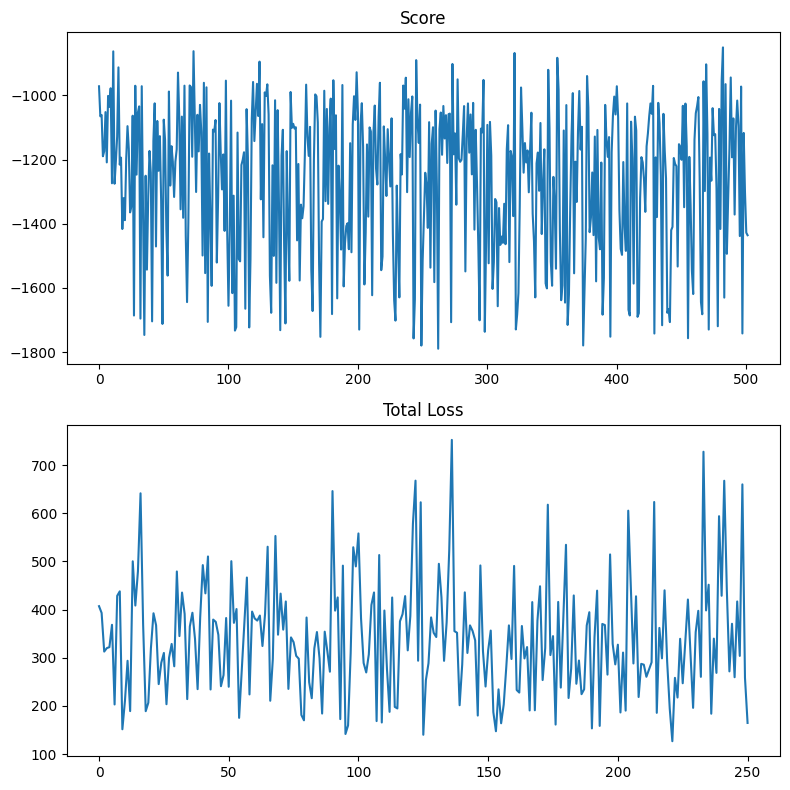

251
252
253
254
255
256


In [ ]:
########################### KEEEP THIS FOR EQ-9 ################################
## I ran this part w.r.t to the loss function mentioned in Eq 9
for config in [[True, True]]:
  print(config)
  polModel = PolModel(obs_dim).to(device)
  valModel = ValModel(obs_dim).to(device)
  pol_optimizer = optim.Adam(polModel.parameters(), lr=1e-3)
  val_optimizer = optim.Adam(valModel.parameters(), lr=5e-3)
  history = History()
  total_actor_loss = []
  total_critic_loss = []
  scores = []

  for step in range(epochs):
    print(step)
    dataCollection()
    trainModel(config)
    if step%10 == 0:
      _plot_train_history()

In [ ]:
!pip install pygame 

import os
os.environ['SDL_VIDEODRIVER']='dummy'
